# Benchmark of methods for brain tumor segmentation 

In [1]:
import warnings
warnings.filterwarnings('ignore')

import nibabel as nib
from math import sqrt
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats
import numpy as np
import cv2 as cv
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from skfuzzy.cluster import cmeans
from dipy.segment.mask import median_otsu
from time import time
import glob
from tqdm import tqdm_notebook as tqdm
%matplotlib inline

N_ITERS = 10

# Extracting and preprocessing 

In [2]:
NUMPASS = 5
MEDIAN_RADIUS = 11
HIT = 0.25
BLUR_RADIUS = 3


N_CLUSTERS = 5
N_COMPONENTS = 2

M = 2.0
EPS = 0.01
MAX_IT = 100
    
K1 = np.ones((3, 3), np.uint16)

IMG_ROOT = '/Users/macbook/Documents/Education/4_Year/DiplomaWork/Images/brain/TCIA Low grade glioma/nifti/'

def get_data(root, patients):
    for patient in tqdm(patients, desc='Loading images'):
        img_path = root + 'LGG-%s/LGG-%s_T2.nii.gz' % (patient[0], patient[0])
        seg_path = root + 'LGG-%s/LGG-%s-Segmentation.nii.gz' % (patient[0], patient[0])
        img = nib.load(img_path).get_data()[:, :, patient[1]]
        seg = nib.load(seg_path).get_data()[:, :, patient[1]]
        yield (img, seg)
    
def draw(img, size=(8, 8), cmap='jet'):
    plt.figure(figsize=size)
    plt.imshow(img, cmap=cmap)
    plt.plot()
    

# from random import shuffle

# def get_data():
#     NUM = 0
#     for img_path, seg_path in zip(glob.glob(IMG_ROOT + '/**/*T2.nii.gz'), glob.glob(IMG_ROOT + '/**/*Segmentation.nii.gz')):
#         img = nib.load(img_path).get_data()
#         seg = nib.load(seg_path).get_data()
#         s = np.sum(seg.reshape((seg.shape[2], -1)).astype(np.int32), axis=1)
#         indicies = s > 0
#         LEN = indicies.shape[0]
#         NUM += LEN
#         indicies = indicies.reshape((-1))
#         if NUM > LIMIT:
#             raise StopIteration
#         else:
#             print(s)
#             indicies = np.argwhere(indicies).reshape(-1)
#             print(indicies)
#             img2 = img[:, :, indicies]
            
#             seg2 = seg[:, :, indicies]
            
#             print(seg2.shape)
#             print(np.sum(seg2.reshape((seg2.shape[2], -1)).astype(np.int32), axis=1))
#             yield img2[:, :, 4], seg2[:, :, 4]
        

        
def preprocess(data):
    for data_ in tqdm(data, desc='Preprocessing'):
        img = data_[0].astype(np.float32)
        img = cv.medianBlur(img, 3)
        img, _ = median_otsu(img, numpass=NUMPASS, median_radius=MEDIAN_RADIUS)
        original_shape = img.shape
        img = ((img - np.min(img)) / (np.max(img) - np.min(img))).astype(np.float32)
        blurred = cv.blur(img, (19, 19))
        edges = np.clip(img - blurred, 0.0, 1.0)
        edges[edges > HIT] = 1.0
        edges[edges <= HIT] = 0.0
        edges = cv.dilate(edges, np.ones((2, 2)), iterations=1)
        img = np.clip(img - edges, 0.0, 1.0)
        yield (img, data_[1])
    
PATIENTS = [
    ('104', 38),  
    ('220', 25),
    ('225', 35),
    ('229', 14),
    ('249', 35),
    ('374', 45),
    ('600', 25),
    ('500', 33),
    ('547', 39),
    ('311', 39),
    (357, 35),
    (387, 16),
    (345, 30),
    (346, 48),
    (351, 24),
    (354, 28),
    (355, 40),
    (357, 36),
    (359, 33),
    (360, 24),
    (361, 19),
    (363, 23),
    (365, 28),
    (367, 28),
    (371, 35),
    (373, 34),
    (374, 44),
    (375, 43),
    (377, 38),
    (380, 37),
    (383, 38),
    (385, 36),
    (388, 43),
    (391, 25),
    (394, 38),
    (396, 37),
    (492, 40),
    (500, 34),
    (506, 26),
    (515, 25),
    (516, 43),
    (518, 49),
    (519, 23),
    (520, 33),
] 

N = len(PATIENTS)
print(N)

DATA = list(get_data(IMG_ROOT, PATIENTS))
PREP = list(preprocess(DATA))

# INDEX = 0
# orig = DATA[INDEX][0]
# # image = PREP[INDEX][0]
# gt = DATA[INDEX][1]

# # res, labels = multivariate_kmeans(image)
# # print('Dice (%)', calc_dice(res, gt))
# # draw(orig)
# # # draw(labels)
# # # draw(res)
# # draw(gt)

# plt.figure(figsize=(8, 8))
# plt.imshow(orig, 'gray')
# plt.imshow(gt, alpha=0.3)

# plt.plot()

44


# K Means

In [3]:
def kmeans(img, n_clusters):
    img = cv.blur(img, (15, 15))
    x = img.reshape((-1, 1))
    model = KMeans(n_clusters=n_clusters, random_state=0, algorithm='full', precompute_distances=False, n_init=1)
    model.fit(x)
    c_index = np.argmax(model.cluster_centers_.reshape((-1)))
    flat = np.full(img.shape[0] * img.shape[1], 0, dtype=np.uint8)
    flat[model.labels_ == c_index] = 1
    mask = flat.reshape(img.shape)
    mask = cv.dilate(mask, K1, iterations=1)
    mask = cv.erode(mask, K1, iterations=1)
    return mask

# Weighted Multivariate K Means

In [4]:
def multivariate_kmeans(img, n_clusters):
    f1 = cv.blur(img, (7, 7)).reshape((-1, 1))
    f2 = cv.blur(img, (9, 9)).reshape((-1, 1)) 
    f3 = cv.blur(img, (5, 5)).reshape((-1, 1)) 
    f4 = img.reshape((-1, 1)) * 0.45
    xc = np.linspace(0, 1.0, img.shape[1])
    yc = np.linspace(0, 1.0, img.shape[0])
    f5 = np.transpose([np.tile(xc, len(xc)), np.repeat(yc, len(yc))]).reshape((-1, 2)) * 0.015
    f3 = cv.blur(img, (5, 5)).reshape((-1, 1)) 
    X = np.concatenate((f1, f2, f3, f4, f5), axis=1)
    x = X
    model = KMeans(n_clusters=n_clusters, random_state=0, algorithm='full', precompute_distances=False, n_init=1)
    model.fit(x)
    c_index = np.argmax(model.cluster_centers_[:,3])
    flat = np.full(img.shape[0] * img.shape[1], 0, dtype=np.uint8)
    flat[model.labels_ == c_index] = 1
    mask = flat.reshape(img.shape)
    mask = cv.erode(mask, K1, iterations=1)
    mask = cv.dilate(mask, K1, iterations=1)
    return mask

# Fuzzy C Means

In [5]:
def fcm(img, n_clusters):
    M = 2
    img = cv.blur(img, (15, 15))
    flat = img.reshape((1, -1))
    c, u, a1, a2, a3, a4, a5 = cmeans(flat, n_clusters, M, EPS, 50)
    tumor_index = np.argmax(c, axis=0)
    defuz = np.argmax(u, axis=0)
    mask = np.full(defuz.shape[0], 0, dtype=np.uint16)
    mask[defuz == tumor_index] = 1
    mask = mask.reshape(img.shape)
    mask = cv.erode(mask, K1, iterations=1)
    mask = cv.dilate(mask, K1, iterations=1)
    return mask

# Gaussian Mixture

In [6]:
def gaussian_mixture(img, n_components):
    img = cv.blur(img, (15, 15))
    x = img.reshape((-1, 1))
    model = GaussianMixture(n_components=n_components, covariance_type='spherical')
    model.fit(x)
    labels = model.predict(x)
    c_index = np.argmax(model.means_)
    flat = np.full(img.shape[0] * img.shape[1], 0, dtype=np.uint8)
    flat[labels == c_index] = 1
    mask = flat.reshape(img.shape)
    mask = cv.erode(mask, K1, iterations=1)
    mask = cv.dilate(mask, K1, iterations=1)
    return mask

# Binary thresholding

In [7]:
def find_threshold_cpu(img, max_it=100, eps=0.001):
    cols = img.shape[1]

    mid = cols // 2
    p1 = img[:, :mid].reshape((-1))
    p2 = img[:, mid:].reshape((-1))
    img = img.reshape((-1))

    it = -1
    while True:
        t1 = np.mean(p1)
        t2 = np.mean(p2)

        t = (t1 + t2) / 2.0
        it += 1
        if it >= max_it or abs(t1 - t2) <= eps:
            return t
        else:
            p1 = img[img < t]
            p2 = img[img >= t]
        
def threshold(img):
    t = find_threshold_cpu(img, max_it=MAX_IT, eps=EPS)
    mask = (img > t).astype(np.int16)
    mask = cv.erode(mask, K1, iterations=1)
    mask = cv.dilate(mask, K1, iterations=1)
    return mask

In [8]:
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule

import cv2 as cv
import numpy as np
from dipy.segment.mask import median_otsu
from pydicom import Dataset

from jinja2 import Template
import numpy as np

BLOCKDIM = 1024

SRC = '''
    #define N {{N}}
    #define BLOCKDIM 1024
    
    struct Cluster{
        float sum;
        int count;
    };
    
    __device__ Cluster clusters_d[(N + BLOCKDIM - 1) / BLOCKDIM];
    
    __device__ float euclidian_dist(const float a, const float b){
        float dist = a - b;
        return hypotf(dist, dist);
    }
    
    __global__ void relabel(const float* src, const float* clusters, int n, int nClusters, int* labels){
        int pos = threadIdx.x + blockIdx.x * blockDim.x;
        if(pos < n){
            float minDist = 1.0f;
            int clusterIndex = 0;
            for(int c = 0; c < nClusters; c++){
                float dist = euclidian_dist(src[pos], clusters[c]);
                if(dist <= minDist){
                    clusterIndex = c;
                    minDist = dist;
                }
            }
            labels[pos] = clusterIndex;
        }
    }
    
    __global__ void calculateClusters(const float* src, const int* labels, int n, int clusterIndex){
        extern __shared__ Cluster _clusters[];
        int pos = threadIdx.x + blockIdx.x * blockDim.x;
        int tid = threadIdx.x;
        _clusters[tid] = Cluster();
        _clusters[tid].sum = 0.0f;
        _clusters[tid].count = 0;
        if(pos < n && labels[pos] == clusterIndex){
            _clusters[tid].sum = src[pos];
            _clusters[tid].count = 1;
        }
        __syncthreads();
        for(unsigned int stride = blockDim.x / 2; stride > 0; stride /= 2){
            if(threadIdx.x < stride){
                _clusters[tid].sum += _clusters[tid + stride].sum;
            }
            __syncthreads();
            if(threadIdx.x < stride){
                _clusters[tid].count += _clusters[tid + stride].count;
            }
            __syncthreads();
        }
        __syncthreads();
        if(threadIdx.x == 0){
            clusters_d[blockIdx.x].sum = _clusters[0].sum;
            clusters_d[blockIdx.x].count = _clusters[0].count;
        }
    }
    
    __global__ void findCenters(int n, int clusterIndex, float* dst){
        extern __shared__ Cluster _clusters[];
        int pos = threadIdx.x + blockIdx.x * blockDim.x;
        int tid = threadIdx.x;
        _clusters[tid] = clusters_d[pos];
        __syncthreads();
        for(unsigned int stride = blockDim.x / 2; stride > 0; stride /= 2){
            if(tid < stride){
                _clusters[tid].sum += _clusters[tid + stride].sum;
            }
            __syncthreads();
            if(tid < stride){
                _clusters[tid].count += _clusters[tid + stride].count;
            }
            __syncthreads();
        }
        __syncthreads();
        if(tid == 0){
            dst[clusterIndex] = _clusters[0].count > 0 ? _clusters[0].sum / (_clusters[0].count * 1.0f) : 0.0f;
        }
    }
'''

def cuda_kmeans(img, n_clusters):
        w = img.shape[1]
        h = img.shape[0]
        n = w * h
        max_it = 30

        img = cv.blur(img, (13, 13))
        src = img.reshape((-1))

        module = SourceModule(Template(SRC).render(N=n))
        relabel = module.get_function('relabel')
        calculate_clusters = module.get_function('calculateClusters')
        find_centers = module.get_function('findCenters')

        t0 = time() * 1000
        centers = np.random.rand(n_clusters).astype(np.float32)

        # Image
        src_gpu = cuda.mem_alloc(src.nbytes)
        cuda.memcpy_htod(src_gpu, src)

        # Cluster centers

        centers_gpu = cuda.mem_alloc(centers.nbytes)
        cuda.memcpy_htod(centers_gpu, centers)

        # Labels
        labels = np.empty_like(src).astype(np.int32)
        labels_gpu = cuda.mem_alloc(labels.nbytes)
        cuda.memcpy_htod(labels_gpu, labels)
        
        start = cuda.Event()
        end = cuda.Event()
        
        t1 = time() * 1000
        
        start.record()
        for it in range(max_it):
            relabel(src_gpu, centers_gpu, np.int32(n), np.int32(n_clusters), labels_gpu,
                    block=(BLOCKDIM, 1, 1), grid=((n + BLOCKDIM - 1) // BLOCKDIM, 1))
            for c in range(n_clusters):
                calculate_clusters(src_gpu, labels_gpu, np.int32(n), np.int32(c),
                                   block=(BLOCKDIM, 1, 1), grid=((n + BLOCKDIM - 1) // BLOCKDIM, 1),
                                   shared=8 * BLOCKDIM)
                find_centers(np.int32(n), np.int32(c), centers_gpu,
                             block=((n + BLOCKDIM - 1) // BLOCKDIM, 1, 1), grid=((1, 1)),
                             shared=8 * (n + BLOCKDIM - 1) // BLOCKDIM)

        
        end.record()
        end.synchronize()
        msecs = end.time_since(start)*1e-3
        msecs *= 1000
        msecs += t1 - t0
        
        t0 = time() * 1000
        cuda.memcpy_dtoh(labels, labels_gpu)
        cuda.memcpy_dtoh(centers, centers_gpu)
#
        labels = labels.reshape((-1))
        c_index = np.argmax(centers)
        flat = np.full(n, 0, dtype=np.uint8)
        flat[labels == c_index] = 1
        mask = flat.reshape((h, w))
        mask = cv.erode(mask, kernel=K1, iterations=1)
        mask = cv.dilate(mask, kernel=K1, iterations=1)
        t1 = time() * 1000
        msecs += t1 - t0
        return mask, msecs

cuda_kmeans.is_cuda = True

# Profile average time and accuracy (Dice-Sørensen) per image

In [9]:
import collections
ALGS = collections.OrderedDict()
ALGS['K Means'] = kmeans
# ALGS['Fuzzy C Means'] = fcm
ALGS['Gaussian Mixture'] = gaussian_mixture
# ALGS['Multivariate K Means'] = multivariate_kmeans
ALGS['CUDA K Means'] = cuda_kmeans


def t(alpha, gl):
    return scipy.stats.t.ppf(1-(alpha/2), gl)

TP_INDEX = 0
FP_INDEX = 1
FN_INDEX = 2
DC_INDEX = 3
PR_INDEX = 4
RC_INDEX = 5
F1_INDEX = 6

def calc_accuracy(seg, gt):
    size = seg.shape[0] * seg.shape[1]
    tp = np.sum(seg[gt==1])
    tn = np.sum(seg[gt==0])
    
    fp = np.sum((gt==0) & (seg==1))
    fn = np.sum((gt==1) & (seg==0))
    dc = 2.0 * tp / (np.sum(gt) + np.sum(seg)) * 100.0

    precision = tp / (tp + fp) * 100.0 
    recall = tp / (tp + fn) * 100.0

    tp = tp * 100.0 / size
    fp = fp * 100.0 / size
    fn = fn * 100.0 / size
    return dc

def profile(alg, data, n_clusters):
    avg_time = []
    avg_accuracy = []
    for data_item in iter(data):
        time_it = []
        accuracy_it = []
        img, gt = data_item[0], data_item[1]
        for i in range(N_ITERS):
            duration = 0.0
            if getattr(alg, 'is_cuda', False):
                seg, duration = alg(img, n_clusters)
            else:
                t0 = time()
                seg = alg(img, n_clusters)
                t1 = time()
                duration = (t1 - t0) * 1000.0
            
            time_it.append([duration])
            accuracy_it.append(calc_accuracy(seg, gt))
        avg_time.append(np.mean(time_it))
        avg_accuracy.append(np.max(accuracy_it))
    return avg_time, avg_accuracy

In [10]:
N_CLUSTERS_RANGE = (3, 10)
t_avg_accuracy = []
conf95_accuracy = []

t_avg_time = []
conf95_time = []

CONF_INT_COEFF = 1.0 / sqrt(N) * t(0.05, N - 1)

avg_time_per_n_clusters = []
avg_acc_per_n_clusters = []

for N_CLUSTERS in tqdm(range(N_CLUSTERS_RANGE[0], N_CLUSTERS_RANGE[1]), desc='Collecting data'):
    print('================================')
    print('N CLUSTERS = ', N_CLUSTERS)
    print('================================')
    time_t, accuracy_t = {}, {}
    for alg in tqdm(ALGS.keys()):
        avg_time, avg_accuracy = profile(ALGS[alg], PREP, N_CLUSTERS)
        time_t[alg] = avg_time
        accuracy_t[alg] = avg_accuracy

    print('Average time per image')
    print(time_t)
    print('\n')

    print('Average accuracy per image')
    print(accuracy_t)
    print('\n')

    
    t_avg_time_alg = []
    t_avg_accuracy_alg = []
    conf95_time_alg = []
    conf95_accuracy_alg = []
    
    avg_time_per_alg = []
    for alg, time_per_image in tqdm(time_t.items(), desc='Avg time per algorithm (N_CLUSTERS = %d)' % N_CLUSTERS):
        avg_time_per_alg.append(time_per_image)
        t_avg_time_ = np.mean(time_per_image)
        t_std_time_ = np.std(time_per_image)
        t_avg_time_alg.append(t_avg_time_)
#         t_std_time[i].append(t_std_time_)
        conf95_time_alg.append(
            [
                t_avg_time_ - t_std_time_ * CONF_INT_COEFF, 
                t_avg_time_ + t_std_time_ * CONF_INT_COEFF
            ]
        )
    avg_time_per_n_clusters.append(avg_time_per_alg)

    avg_acc_per_alg = []
    for alg, accuracy_per_image in tqdm(accuracy_t.items(), desc='Avg acc per algorithm (N_CLUSTERS = %d)' % N_CLUSTERS):
        avg_acc_per_alg.append(accuracy_per_image)
        t_avg_accuracy_ = np.mean(accuracy_per_image)
        t_std_accuracy_ = np.std(accuracy_per_image)
        t_avg_accuracy_alg.append(t_avg_accuracy_)
#         t_std_accuracy[i].append(t_std_accuracy_)
        conf95_accuracy_alg.append(
            [
                t_avg_accuracy_ - t_std_accuracy_ * CONF_INT_COEFF, 
                t_avg_accuracy_ + t_std_accuracy_ * CONF_INT_COEFF
            ]
        )
    avg_acc_per_n_clusters.append(avg_time_per_alg)
    
    t_avg_time.append(t_avg_time_alg)
    t_avg_accuracy.append(t_avg_accuracy_alg)
    conf95_time.append(conf95_time_alg)
    conf95_accuracy.append(conf95_accuracy_alg)

print('Total average time (msecs)')
print(t_avg_time)
print('\n')

# print('Total std of time (msecs)^2')
# print(t_std_time)
# print('\n')

print('95% Confidence interval of time (msecs)')
print(conf95_time)
print('\n')

print('Total average accuracy (%)')
print(t_avg_accuracy)
print('\n')

#     print('Total std of accuracy (%)')
#     print(t_std_accuracy)
#     print('\n')

print('95% Confidence interval of accuracy (%)')
print(conf95_accuracy)
print('\n')

N CLUSTERS =  3


Average time per image
{'K Means': [24.35152530670166, 41.110825538635254, 93.92101764678955, 15.60981273651123, 20.098114013671875, 22.975778579711914, 20.09742259979248, 29.53495979309082, 46.048712730407715, 24.935173988342285, 17.861199378967285, 135.3639841079712, 18.546438217163086, 16.664671897888184, 19.30069923400879, 17.43783950805664, 22.469401359558105, 13.855504989624023, 34.52329635620117, 29.20403480529785, 85.55412292480469, 19.8972225189209, 22.304511070251465, 18.211913108825684, 25.382351875305176, 26.38227939605713, 24.300003051757812, 15.504002571105957, 22.51424789428711, 14.457082748413086, 19.70043182373047, 25.445961952209473, 39.24908638000488, 14.299154281616211, 18.61262321472168, 17.231225967407227, 40.77267646789551, 50.51264762878418, 18.213915824890137, 78.3273458480835, 33.90040397644043, 61.98720932006836, 31.06672763824463, 16.4337158203125], 'Gaussian Mixture': [190.4585599899292, 208.15799236297607, 277.40352153778076, 222.4971055984497, 231.5296173

N CLUSTERS =  4


Average time per image
{'K Means': [34.55379009246826, 52.33147144317627, 40.482401847839355, 25.377368927001953, 27.9252290725708, 58.33179950714111, 92.64640808105469, 42.62828826904297, 31.56440258026123, 33.90381336212158, 34.4771146774292, 116.2445068359375, 29.966187477111816, 27.884507179260254, 29.745769500732422, 36.858558654785156, 34.833478927612305, 31.784582138061523, 52.022504806518555, 60.6548547744751, 72.03452587127686, 35.86456775665283, 66.94731712341309, 23.981499671936035, 24.672245979309082, 201.41758918762207, 87.2539758682251, 34.247660636901855, 30.23066520690918, 24.625706672668457, 50.49629211425781, 61.48691177368164, 30.083775520324707, 62.25638389587402, 52.9735803604126, 42.10395812988281, 31.957435607910156, 28.225064277648926, 26.433110237121582, 125.42927265167236, 61.03827953338623, 25.53117275238037, 38.55853080749512, 24.89769458770752], 'Gaussian Mixture': [211.57546043395996, 224.04921054840088, 252.81598567962646, 238.27857971191406, 214.07809257

N CLUSTERS =  5


Average time per image
{'K Means': [68.91276836395264, 39.756155014038086, 57.72838592529297, 33.25331211090088, 36.83369159698486, 34.5217227935791, 110.04400253295898, 75.43168067932129, 52.512383460998535, 32.140493392944336, 41.103339195251465, 246.54123783111572, 50.45497417449951, 42.668819427490234, 34.29560661315918, 48.590779304504395, 61.9152307510376, 32.48310089111328, 32.11197853088379, 38.359999656677246, 105.74750900268555, 56.99045658111572, 56.77385330200195, 26.358580589294434, 40.527963638305664, 69.10595893859863, 36.74812316894531, 64.14153575897217, 40.56074619293213, 48.123764991760254, 29.063796997070312, 25.054407119750977, 69.67425346374512, 42.96398162841797, 25.524163246154785, 204.88147735595703, 47.88665771484375, 73.47919940948486, 98.55732917785645, 150.52828788757324, 77.72603034973145, 83.54120254516602, 48.20237159729004, 37.80224323272705], 'Gaussian Mixture': [278.5569667816162, 331.57217502593994, 300.95906257629395, 269.95980739593506, 276.5412569

N CLUSTERS =  6


Average time per image
{'K Means': [61.71731948852539, 62.410831451416016, 97.3686933517456, 48.74606132507324, 44.50550079345703, 72.84531593322754, 128.0198335647583, 89.11230564117432, 43.166184425354004, 63.259100914001465, 53.93989086151123, 215.71178436279297, 98.04544448852539, 85.47756671905518, 150.74551105499268, 100.51696300506592, 82.81059265136719, 44.35310363769531, 50.13110637664795, 51.450347900390625, 56.996726989746094, 55.286598205566406, 133.21335315704346, 52.8125524520874, 56.75954818725586, 47.241830825805664, 129.69329357147217, 72.72536754608154, 47.825050354003906, 89.73920345306396, 39.59000110626221, 38.730740547180176, 131.91115856170654, 70.99182605743408, 66.81561470031738, 87.85502910614014, 78.67660522460938, 100.3673791885376, 104.69973087310791, 235.18743515014648, 84.31072235107422, 91.15135669708252, 48.06082248687744, 116.43178462982178], 'Gaussian Mixture': [277.14829444885254, 314.853572845459, 339.54484462738037, 342.8267002105713, 340.395998954

N CLUSTERS =  7


Average time per image
{'K Means': [105.3105354309082, 123.82678985595703, 151.88417434692383, 91.64347648620605, 44.91300582885742, 55.15315532684326, 110.49234867095947, 47.46580123901367, 141.37368202209473, 55.54862022399902, 72.58026599884033, 297.2116947174072, 109.59651470184326, 115.22345542907715, 68.70081424713135, 51.82480812072754, 74.40392971038818, 181.74140453338623, 151.16333961486816, 140.81847667694092, 49.494314193725586, 60.396742820739746, 139.7073745727539, 150.17218589782715, 96.11673355102539, 184.2250108718872, 87.12761402130127, 77.29251384735107, 168.8978672027588, 45.22440433502197, 68.36519241333008, 89.80391025543213, 45.323801040649414, 77.33991146087646, 137.09092140197754, 53.803205490112305, 97.34957218170166, 58.258914947509766, 55.48567771911621, 283.5893392562866, 125.38106441497803, 98.86660575866699, 57.891106605529785, 186.7414951324463], 'Gaussian Mixture': [345.24784088134766, 432.2021484375, 386.5617275238037, 378.4851551055908, 440.1103258132

N CLUSTERS =  8


Average time per image
{'K Means': [93.31529140472412, 78.80744934082031, 75.98686218261719, 65.75784683227539, 281.77154064178467, 154.1322946548462, 225.25978088378906, 85.63966751098633, 124.26989078521729, 89.8632287979126, 114.33167457580566, 852.0599603652954, 74.65236186981201, 273.89400005340576, 82.31589794158936, 142.1680212020874, 85.70668697357178, 67.93172359466553, 102.60515213012695, 79.97963428497314, 84.26671028137207, 99.13392066955566, 138.5984182357788, 114.05670642852783, 208.622145652771, 74.14672374725342, 58.556389808654785, 59.90478992462158, 54.36906814575195, 71.10044956207275, 90.9813642501831, 102.05252170562744, 128.5797119140625, 53.03919315338135, 70.2568769454956, 271.22809886932373, 79.07044887542725, 83.5869550704956, 109.64181423187256, 784.7817182540894, 161.2502098083496, 313.6073112487793, 107.61106014251709, 76.85253620147705], 'Gaussian Mixture': [408.19759368896484, 421.8465805053711, 483.64574909210205, 399.59402084350586, 417.3548460006714, 4

N CLUSTERS =  9


Average time per image
{'K Means': [82.67688751220703, 59.458279609680176, 87.55183219909668, 186.8659496307373, 76.54368877410889, 74.67875480651855, 337.151575088501, 327.2664785385132, 84.79278087615967, 115.4510498046875, 131.736421585083, 510.57379245758057, 100.07791519165039, 105.16037940979004, 74.84550476074219, 80.45501708984375, 63.366079330444336, 102.9897689819336, 105.76579570770264, 98.11410903930664, 75.66497325897217, 140.30468463897705, 88.3436918258667, 104.47890758514404, 89.49136734008789, 178.35659980773926, 88.24636936187744, 141.7790651321411, 191.6494369506836, 88.00520896911621, 113.57896327972412, 80.82480430603027, 77.00023651123047, 79.81564998626709, 139.3782377243042, 120.03076076507568, 240.89996814727783, 60.303497314453125, 175.37879943847656, 342.76862144470215, 148.40409755706787, 94.15338039398193, 99.33233261108398, 84.8482608795166], 'Gaussian Mixture': [421.8333959579468, 559.1383695602417, 554.5280694961548, 529.559588432312, 496.43635749816895,


Total average time (msecs)
[[31.912983547557484, 250.83396326411855, 21.041653849861838], [49.02191487225619, 276.29934332587504, 25.15742429386485], [62.036899003115565, 318.4749792922627, 31.15182054693049], [83.6683452129364, 370.0789142738689, 36.35587107484991], [106.47322210398588, 445.14880017800766, 44.15090852217241], [148.76691157167608, 489.1648254611275, 47.67810733101585], [132.9218176278201, 549.5258309624412, 52.0404901938005]]


95% Confidence interval of time (msecs)
[[[24.532093640576154, 39.29387345453881], [203.78577688001957, 297.88214964821753], [17.878547082805134, 24.20476061691854]], [[38.993279457227885, 59.050550287284494], [221.6862481774976, 330.9124384742525], [21.327039431014835, 28.987809156714864]], [[48.66103445103141, 75.41276355519972], [261.235022397772, 375.71493618675333], [26.485903364791945, 35.81773772906904]], [[70.83033192800929, 96.50635849786352], [309.16002364362447, 430.99780490411337], [30.994995101799425, 41.71674704790039]], [[88.8850

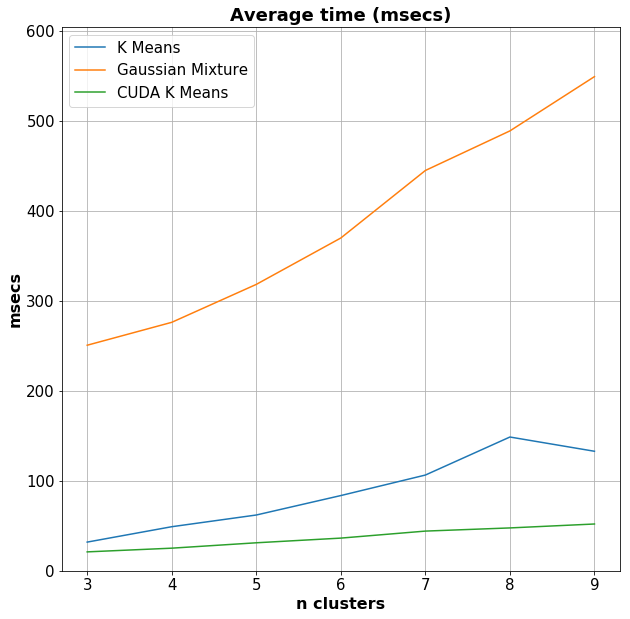

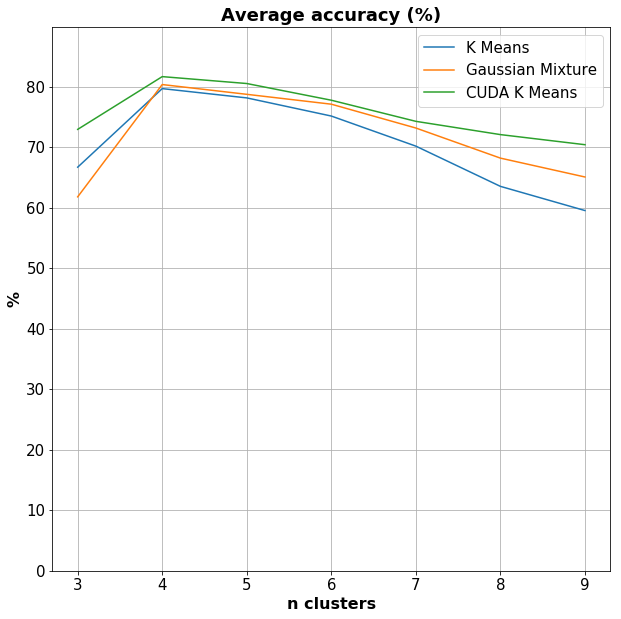



-----> K Means <-----


[Average time]
[ 31.91298355  49.02191487  62.036899    83.66834521 106.4732221
 148.76691157 132.92181763]


[Average accuracy]
[66.71818937 79.70465936 78.16947927 75.16909958 70.19522561 63.54637998
 59.54883472]


[Conf 95% time]
[[ 24.53209364  39.29387345]
 [ 38.99327946  59.05055029]
 [ 48.66103445  75.41276356]
 [ 70.83033193  96.5063585 ]
 [ 88.88507927 124.06136494]
 [100.16934808 197.36447507]
 [105.62622165 160.21741361]]


[Conf 95% accuracy]
[[57.25880521 76.17757354]
 [74.75980273 84.64951599]
 [73.71314982 82.62580872]
 [70.70933584 79.62886332]
 [65.95420257 74.43624866]
 [58.89921128 68.19354867]
 [55.14451786 63.95315159]]


-----> Gaussian Mixture <-----


[Average time]
[250.83396326 276.29934333 318.47497929 370.07891427 445.14880018
 489.16482546 549.52583096]


[Average accuracy]
[61.81377748 80.37642535 78.76085937 77.12973543 73.18949324 68.21476009
 65.0954381 ]


[Conf 95% time]
[[203.78577688 297.88214965]
 [221.68624818 330.912438

In [11]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 10
rcParams['legend.fontsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['ytick.labelsize'] = 15

res_time = np.asarray(t_avg_time)
res_acc = np.asarray(t_avg_accuracy)
conf95_time_res = np.asarray(conf95_time)
conf95_acc_res = np.asarray(conf95_accuracy)

avg_time_per_n_clusters = np.asarray(avg_time_per_n_clusters)
avg_acc_per_n_clusters = np.asarray(avg_acc_per_n_clusters)

X = np.arange(N_CLUSTERS_RANGE[0], N_CLUSTERS_RANGE[1])
plt.title('Average time (msecs)', fontsize=18, fontweight='bold')
plt.xticks(X)
plt.xlabel('n clusters', fontweight="bold", fontsize=16)
plt.ylabel('msecs', fontweight="bold", fontsize=16)
plt.ylim(0, np.max(res_time) * 1.1)
# plt.yscale('log', basey=10)
for i, alg in zip(range(len(ALGS.keys())), ALGS.keys()):
    # ax.set_xticklabels(['K=%d' % k for k in range(3, 6)])
    plt.plot(X, res_time[:,i], label=alg)
#     plt.fill_between(X, conf95_time_res[:,i,0], conf95_time_res[:,i,1], alpha=0.15)
    # plt.axis('equal')
plt.legend()
plt.grid()
plt.show()


plt.title('Average accuracy (%)', fontsize=18, fontweight='bold')
plt.xticks(X)
plt.xlabel('n clusters', fontweight="bold", fontsize=16)
plt.ylabel('%', fontweight="bold", fontsize=16)
plt.ylim(0, np.max(res_acc) * 1.1)
# plt.yscale('log', basey=10)
for i, alg in zip(range(len(ALGS.keys())), ALGS.keys()):
    # ax.set_xticklabels(['K=%d' % k for k in range(3, 6)])
    plt.plot(X, res_acc[:,i], label=alg)
#     plt.fill_between(X, conf95_acc_res[:,i,0], conf95_acc_res[:,i,1], alpha=0.15)
    # plt.axis('equal')
plt.legend()
plt.grid()
plt.show()

import matplotlib
palegreen = matplotlib.colors.colorConverter.to_rgb('#8CFF6F')
paleblue = matplotlib.colors.colorConverter.to_rgb('#708DFF')
    
# for i, alg in zip(range(len(ALGS.keys())), ALGS.keys()):
#     fig = plt.figure(1, figsize=(9, 9))
#     ax = fig.add_subplot(111)
    
#     ax.set_title('%s - Time (msecs)' % alg)
#     bp = ax.boxplot(avg_time_per_n_clusters[:,i,:].T)
#     ax.set_xticklabels(list(range(N_CLUSTERS_RANGE[0], N_CLUSTERS_RANGE[1])))
#     plt.show()

#     fig = plt.figure(1, figsize=(9, 9))
#     ax = fig.add_subplot(111)
    
#     ax.set_title('%s - Accuracy (%%)' % alg)
#     bp = ax.boxplot(avg_acc_per_n_clusters[:,i,:].T)
#     ax.set_xticklabels(list(range(N_CLUSTERS_RANGE[0], N_CLUSTERS_RANGE[1])))
#     plt.show()

for i, alg in zip(range(len(ALGS.keys())), ALGS.keys()):
    print("\n")
    print("===========================")
    print('----->', alg, '<-----')
    print("\n")
    print('[Average time]')
    print(res_time[:,i])
    print("\n")
    print('[Average accuracy]')
    print(res_acc[:,i])
    print("\n")
    print('[Conf 95% time]')
    print(conf95_time_res[:,i,:])
    print("\n")
    print('[Conf 95% accuracy]')
    print(conf95_acc_res[:,i,:])


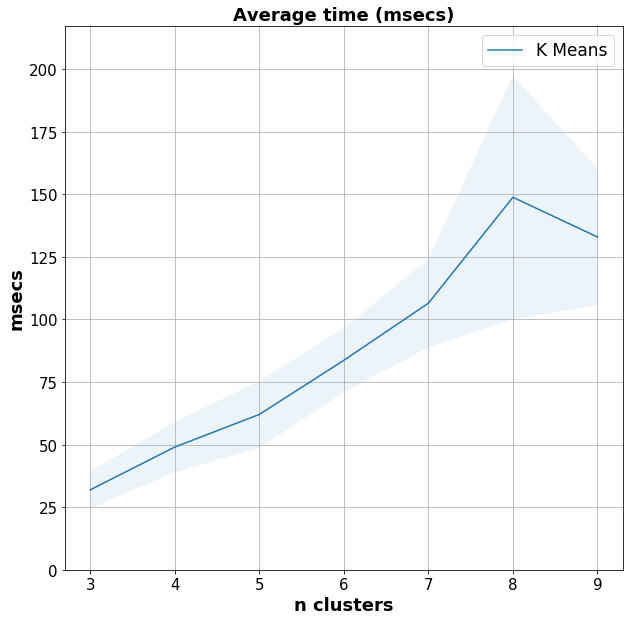

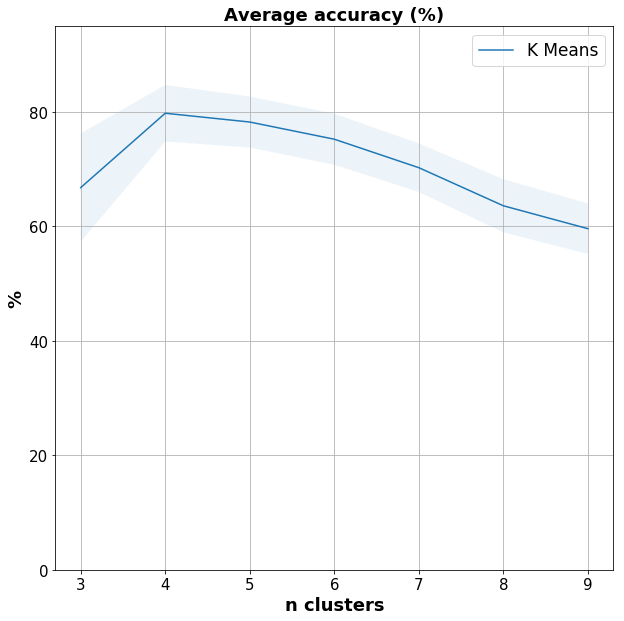



-----> K Means <-----


[Average time]
[ 31.91298355  49.02191487  62.036899    83.66834521 106.4732221
 148.76691157 132.92181763]


[Average accuracy]
[66.71818937 79.70465936 78.16947927 75.16909958 70.19522561 63.54637998
 59.54883472]


[Conf 95% time]
[[ 24.53209364  39.29387345]
 [ 38.99327946  59.05055029]
 [ 48.66103445  75.41276356]
 [ 70.83033193  96.5063585 ]
 [ 88.88507927 124.06136494]
 [100.16934808 197.36447507]
 [105.62622165 160.21741361]]


[Conf 95% accuracy]
[[57.25880521 76.17757354]
 [74.75980273 84.64951599]
 [73.71314982 82.62580872]
 [70.70933584 79.62886332]
 [65.95420257 74.43624866]
 [58.89921128 68.19354867]
 [55.14451786 63.95315159]]


In [12]:
from pylab import rcParams
# rcParams['title.fontsize'] = 18
# rcParams['title.fontname'] = "Times New Roman Bold"
rcParams['figure.figsize'] = 10, 10
rcParams['legend.fontsize'] = 17
rcParams['xtick.labelsize'] = 15
rcParams['ytick.labelsize'] = 15

res_time = np.asarray(t_avg_time)
res_acc = np.asarray(t_avg_accuracy)
conf95_time_res = np.asarray(conf95_time)
conf95_acc_res = np.asarray(conf95_accuracy)

avg_time_per_n_clusters = np.asarray(avg_time_per_n_clusters)
avg_acc_per_n_clusters = np.asarray(avg_acc_per_n_clusters)

X = np.arange(N_CLUSTERS_RANGE[0], N_CLUSTERS_RANGE[1])
plt.title('Average time (msecs)', fontsize=18, fontweight="bold")
plt.xticks(X)
plt.xlabel('n clusters', fontsize=18, fontweight="bold")
plt.ylabel('msecs', fontsize=18, fontweight="bold")
plt.ylim(0, np.max(conf95_time_res[:, [0, 2], 1]) * 1.1)
# plt.yscale('log', basey=10)
for i, alg in zip(range(len(ALGS.keys())), ALGS.keys()):
    # ax.set_xticklabels(['K=%d' % k for k in range(3, 6)])
    if i == 0 or i == 4:
        plt.plot(X, res_time[:,i], label=alg)
        plt.fill_between(X, conf95_time_res[:,i,0], conf95_time_res[:,i,1], alpha=0.08)
    # plt.axis('equal')
plt.legend()
plt.grid()
plt.show()


plt.title('Average accuracy (%)', fontsize=18, fontname="Times New Roman Bold", fontweight="bold")
plt.xticks(X)
plt.xlabel('n clusters', fontsize=18, fontweight="bold")
plt.ylabel('%', fontsize=18, fontweight="bold")
plt.ylim(0, np.max(conf95_acc_res[:, [0, 2], 1]) * 1.1)
# plt.yscale('log', basey=10)
for i, alg in zip(range(len(ALGS.keys())), ALGS.keys()):
    if i == 0 or i == 4:
    # ax.set_xticklabels(['K=%d' % k for k in range(3, 6)])
        plt.plot(X, res_acc[:,i], label=alg)
        plt.fill_between(X, conf95_acc_res[:,i,0], conf95_acc_res[:,i,1], alpha=0.08)
    # plt.axis('equal')
plt.legend()
plt.grid()
plt.show()

import matplotlib
palegreen = matplotlib.colors.colorConverter.to_rgb('#8CFF6F')
paleblue = matplotlib.colors.colorConverter.to_rgb('#708DFF')
    
# for i, alg in zip(range(len(ALGS.keys())), ALGS.keys()):
#     if i == 0 or i == 4:
#         fig = plt.figure(1, figsize=(9, 9))
#         ax = fig.add_subplot(111)

#         ax.set_title('%s - Time (msecs)' % alg)
#         bp = ax.boxplot(avg_time_per_n_clusters[:,i,:].T)
#         ax.set_xticklabels(list(range(N_CLUSTERS_RANGE[0], N_CLUSTERS_RANGE[1])))
#         plt.show()

#         fig = plt.figure(1, figsize=(9, 9))
#         ax = fig.add_subplot(111)

#         ax.set_title('%s - Accuracy (%%)' % alg)
#         bp = ax.boxplot(avg_acc_per_n_clusters[:,i,:].T)
#         ax.set_xticklabels(list(range(N_CLUSTERS_RANGE[0], N_CLUSTERS_RANGE[1])))
#         plt.show()

for i, alg in zip(range(len(ALGS.keys())), ALGS.keys()):
    if i == 0 or i == 4:
        print("\n")
        print("===========================")
        print('----->', alg, '<-----')
        print("\n")
        print('[Average time]')
        print(res_time[:,i])
        print("\n")
        print('[Average accuracy]')
        print(res_acc[:,i])
        print("\n")
        print('[Conf 95% time]')
        print(conf95_time_res[:,i,:])
        print("\n")
        print('[Conf 95% accuracy]')
        print(conf95_acc_res[:,i,:])


In [13]:
import pandas as pd
df_time = pd.DataFrame(np.round(res_time.T, decimals=2), columns=[str(k) for k in range(N_CLUSTERS_RANGE[0], N_CLUSTERS_RANGE[1])])
df_time.index = ALGS.keys()
df_acc = pd.DataFrame(np.round(res_acc.T, decimals=2), columns=[str(k) for k in range(N_CLUSTERS_RANGE[0], N_CLUSTERS_RANGE[1])])
df_acc.index = ALGS.keys()

conf95_time_res[conf95_time_res < 0] = 0
conf95_acc_res[conf95_acc_res < 0] = 0

# Conf 95 time
df_conf_time = np.apply_along_axis(
    lambda x: '[%.2f, %.2f]' % (x[0], x[1]), 
    2, 
    np.round(conf95_time_res, decimals=2)
).T
df_conf_time = pd.DataFrame(df_conf_time, columns=[str(k) for k in range(N_CLUSTERS_RANGE[0], N_CLUSTERS_RANGE[1])])
df_conf_time.index = ALGS.keys()

# Conf 95 accuracy
df_conf_acc = np.apply_along_axis(
    lambda x: '[%.2f, %.2f]' % (x[0], x[1]), 
    2, 
    np.round(conf95_acc_res, decimals=2)
).T
df_conf_acc = pd.DataFrame(df_conf_acc, columns=[str(k) for k in range(N_CLUSTERS_RANGE[0], N_CLUSTERS_RANGE[1])])
df_conf_acc.index = ALGS.keys()

print('Time\n')
print(df_time)
print('\n')

print('Accuracy\n')
print(df_acc)
print('\n')

print('Time (95% confidence interval)\n')
print(df_conf_time)
print('\n')

print('Accuracy (95% confidence interval)\n')
print(df_conf_acc)

writer = pd.ExcelWriter('benchmark_max.xlsx')
df_time.to_excel(writer, 'Time')
df_acc.to_excel(writer, 'Accuracy')
df_conf_time.to_excel(writer, 'Time - 95')
df_conf_acc.to_excel(writer, 'Accuracy - 95')
writer.save()

Time

                       3       4       5       6       7       8       9
K Means            31.91   49.02   62.04   83.67  106.47  148.77  132.92
Gaussian Mixture  250.83  276.30  318.47  370.08  445.15  489.16  549.53
CUDA K Means       21.04   25.16   31.15   36.36   44.15   47.68   52.04


Accuracy

                      3      4      5      6      7      8      9
K Means           66.72  79.70  78.17  75.17  70.20  63.55  59.55
Gaussian Mixture  61.81  80.38  78.76  77.13  73.19  68.21  65.10
CUDA K Means      72.97  81.69  80.55  77.79  74.30  72.10  70.43


Time (95% confidence interval)

                               3               4               5  \
K Means           [24.53, 39.29]  [38.99, 59.05]  [48.66, 75.41]   
Gaussian Mixture  [203.79, 297.8  [221.69, 330.9  [261.24, 375.7   
CUDA K Means      [17.88, 24.20]  [21.33, 28.99]  [26.49, 35.82]   

                               6               7               8  \
K Means           [70.83, 96.51]  [88.89, 124.06  [